<font size="+3"><strong>Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [7]:
# Import libraries here

from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


# Prepare Data

## Import

In [12]:
data=pd.read_csv("data/mexico-city-real-estate-1.csv")
data.head()

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


**Task 1:** Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [15 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 



In [15]:
# Build your `wrangle` function
def wrangle(filepath):
    # 1
    df=pd.read_csv(filepath)
    p=df["property_type"]=="apartment"
    m=df["place_with_parent_names"].str.contains("Distrito Federal")
    d=df["price_aprox_usd"] < 100_000
    
    df=df[p & m & d]
    #2
    low,high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high) 
    df=df[mask_area]
    #3
    df[["lat","lon"]]=df["lat-lon"].str.split(',',expand=True).astype(float)
    df.drop(columns=["lat-lon"],inplace=True)
    #4
    df["borough"]=df["place_with_parent_names"].str.split('|',expand=True)[1]
    df.drop(columns = ["place_with_parent_names"], inplace = True)
    #5
    df.drop(columns=["surface_total_in_m2","price_usd_per_m2","floor","rooms","expenses"],inplace=True)
    #6
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)
    #7
    df.drop(columns = ["price", "price_aprox_local_currency", "price_per_m2","Unnamed: 0"], inplace = True)
    
    return df

In [16]:
# Use this cell to test your wrangle function and explore the data
df=wrangle("data/mexico-city-real-estate-1.csv")
df.head()
#print(df.info())

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


**Task 2:** Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [17]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

**Task 3:** Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [18]:
df = pd.concat(wrangle(file) for file in files)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


## Explore

**Task 4:** Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Price [$]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`. Use Matplotlib (`plt`).

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

Text(0.5, 1.0, 'Distribution of Apartment Prices')

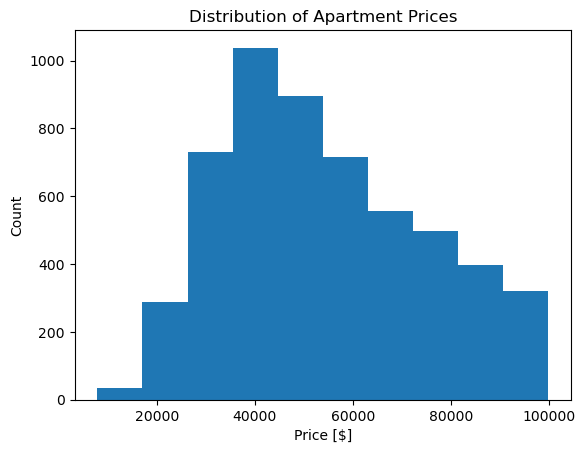

In [20]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")


# Add title
plt.title("Distribution of Apartment Prices")



**Task 5:** Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`. Your plot should have the title `"Mexico City: Price vs. Area"`. Use Matplotlib (`plt`).

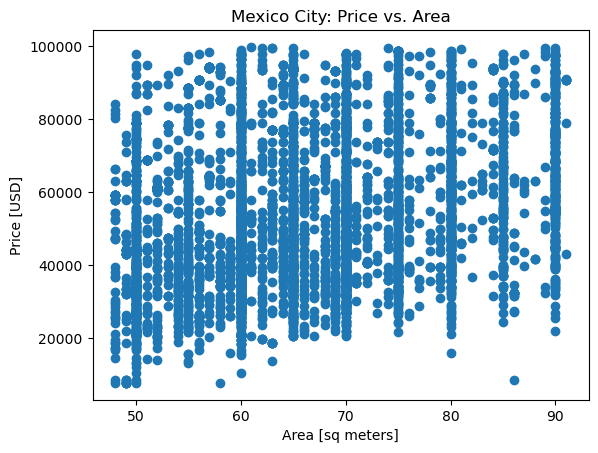

In [22]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"],y=df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area");

## Split

**Task 6:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [23]:
# Split data into feature matrix `X_train` and target vector `y_train`.
features=["surface_covered_in_m2","lat","lon","borough"]
target= "price_aprox_usd"
X_train = df[features]
y_train = df[target]

# Build Model

## Baseline

**Task 7:** Calculate the baseline mean absolute error for your model.

In [24]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


## Iterate

**Task 8:** Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [25]:
# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
)
# Fit model
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

**Task 9:** Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [31]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
X_test.drop(columns="Unnamed: 0",inplace=True)
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


**Task 10:** Use your model to generate a Series of predictions for `X_test`. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [32]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

# Communicate Results

**Task 11:** Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [33]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients,index=features)
feat_imp

C:\Users\kiro\anaconda3\lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_Coyoacán                   3737.561001
borough_Álvaro Obregón             3275.121061
borough_Iztapalapa               -13349.017448
borough_Cuauhtémoc                 -350.531990
borough_Tláhuac                  -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429804
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

**Task 12:** Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`. Use pandas. 

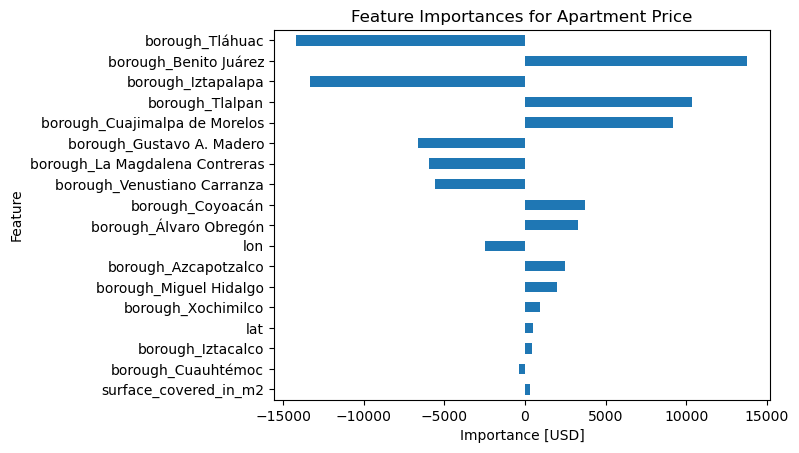

In [35]:
# Build bar chart

feat_imp.sort_values(key= abs).plot(kind= "barh")
# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importances for Apartment Price");